In [10]:
!pip install opendatasets

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn as nn
from torch import optim
from torchvision import models
from PIL import Image
import os

In [9]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.image_paths = []

        for cls in self.classes:
            class_path = os.path.join(root_dir, cls)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                self.image_paths.append((img_path, self.class_to_idx[cls]))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path, label = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Open image & convert to RGB

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Initialize dataset
data_dir = "IS-Project/data/raw-img"
dataset = CustomImageDataset(root_dir=data_dir, transform=train_transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Check dataset properties
print("Classes:", dataset.classes)
print("Class-to-Index Mapping:", dataset.class_to_idx)
print("Total Images:", len(dataset))

# Fetch a batch
images, labels = next(iter(train_loader))
print(f"Batch Shape: {images.shape}, Labels: {labels[:5]}")

Classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Class-to-Index Mapping: {'cane': 0, 'cavallo': 1, 'elefante': 2, 'farfalla': 3, 'gallina': 4, 'gatto': 5, 'mucca': 6, 'pecora': 7, 'ragno': 8, 'scoiattolo': 9}
Total Images: 26179
Batch Shape: torch.Size([32, 3, 224, 224]), Labels: tensor([3, 0, 8, 8, 6])


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
device

device(type='cuda')

In [12]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)
model = model.to(device)

c:\Users\Acer\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Acer\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [ ]:
from tqdm import tqdm
import copy

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=5):
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    early_stop_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc = evaluate(model, val_loader)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss/len(train_loader):.4f} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stop_counter = 0  # Reset counter if accuracy improves
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), "best_model.pth")
    print("Best model saved.")
    return model
# Evaluation Function
def evaluate(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return correct / total

# Train and Evaluate
best_model = train_model(model, train_loader, val_loader, criterion, optimizer)

Epoch 1/50: 100%|██████████| 655/655 [05:36<00:00,  1.95it/s]


Epoch 1/50 - Loss: 0.4288 - Train Acc: 0.8695 - Val Acc: 0.9036


Epoch 2/50: 100%|██████████| 655/655 [03:31<00:00,  3.09it/s]


Epoch 2/50 - Loss: 0.3415 - Train Acc: 0.8904 - Val Acc: 0.9162


Epoch 3/50: 100%|██████████| 655/655 [06:03<00:00,  1.80it/s]


Epoch 3/50 - Loss: 0.3288 - Train Acc: 0.8918 - Val Acc: 0.9102


Epoch 4/50: 100%|██████████| 655/655 [08:13<00:00,  1.33it/s]


Epoch 4/50 - Loss: 0.3078 - Train Acc: 0.9007 - Val Acc: 0.9135


Epoch 5/50: 100%|██████████| 655/655 [04:11<00:00,  2.60it/s]


Epoch 5/50 - Loss: 0.3046 - Train Acc: 0.8982 - Val Acc: 0.9179


Epoch 6/50: 100%|██████████| 655/655 [05:06<00:00,  2.13it/s]


Epoch 6/50 - Loss: 0.3008 - Train Acc: 0.9014 - Val Acc: 0.9236


Epoch 7/50: 100%|██████████| 655/655 [07:12<00:00,  1.52it/s]


Epoch 7/50 - Loss: 0.2984 - Train Acc: 0.9016 - Val Acc: 0.9139


Epoch 8/50: 100%|██████████| 655/655 [08:05<00:00,  1.35it/s]


Epoch 8/50 - Loss: 0.2886 - Train Acc: 0.9052 - Val Acc: 0.9213


Epoch 9/50: 100%|██████████| 655/655 [06:16<00:00,  1.74it/s]


Epoch 9/50 - Loss: 0.2872 - Train Acc: 0.9066 - Val Acc: 0.9202


Epoch 10/50: 100%|██████████| 655/655 [05:42<00:00,  1.91it/s]


Epoch 10/50 - Loss: 0.2886 - Train Acc: 0.9063 - Val Acc: 0.9204


Epoch 11/50: 100%|██████████| 655/655 [06:57<00:00,  1.57it/s]


Epoch 11/50 - Loss: 0.2783 - Train Acc: 0.9083 - Val Acc: 0.9209
Early stopping triggered.
Best model saved.


In [8]:
torch.save(best_model.state_dict(), "Animal10_Restnet18.pth")

NameError: name 'best_model' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..1.0].


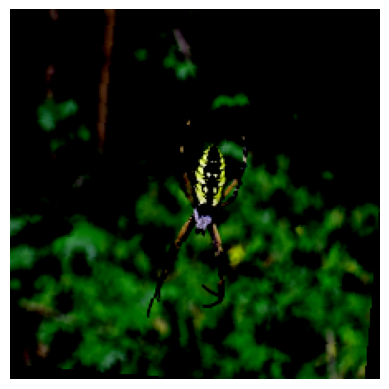

Predicted Label: ragno
Actual Label: ragno


In [16]:
# prompt: load the model and random the image from dataset and show the image predict labels

import matplotlib.pyplot as plt
import random


# Load the trained model
model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)
model.load_state_dict(torch.load("Animal10_Restnet18.pth", map_location=device))
model = model.to(device)
model.eval()

# Choose a random image from the dataset
random_idx = random.randint(0, len(dataset) - 1)
image, label = dataset[random_idx]

# Transpose the image tensor to (H, W, C)
image_display = image.permute(1, 2, 0) # or torch.permute(image, (1,2,0))

# Display the image
plt.imshow(image_display)
plt.axis("off")
plt.show()


# Make prediction
image = image.unsqueeze(0).to(device)
with torch.no_grad():
    outputs = model(image)
    _, predicted = torch.max(outputs, 1)


# Print prediction
print(f"Predicted Label: {dataset.classes[predicted.item()]}")
print(f"Actual Label: {dataset.classes[label]}")

def evaluate(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return correct / total


In [15]:
evaluate(model,val_loader)

0.9182582123758595

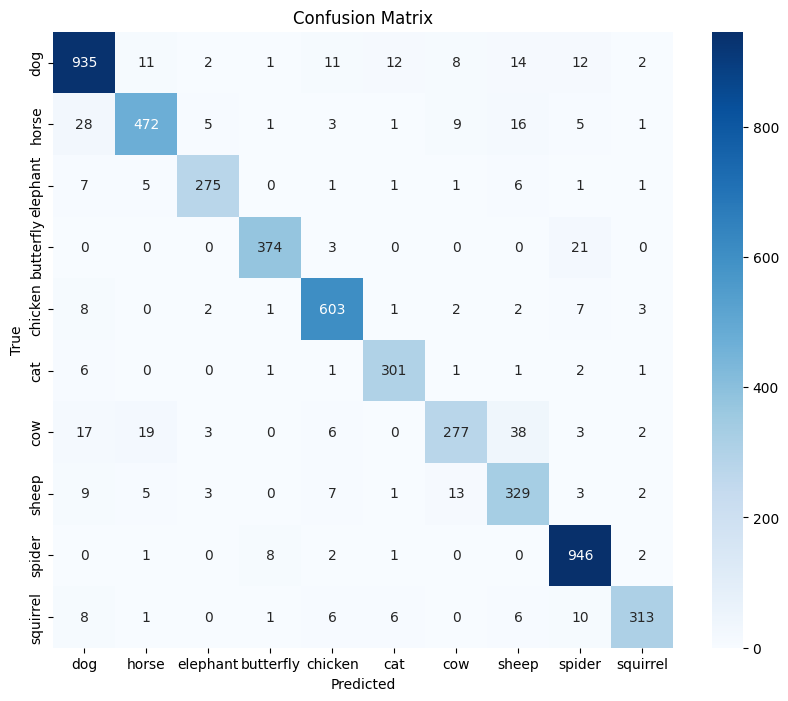

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# Define label translations
translate = {
    "cane": "dog",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "gatto": "cat",
    "mucca": "cow",
    "pecora": "sheep",
    "ragno": "spider",
    "scoiattolo": "squirrel"
}

# Get all true labels and predicted labels
true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Translate class names
translated_classes = [translate[label] for label in dataset.classes]

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=translated_classes, yticklabels=translated_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()